In [40]:
from nilearn import plotting
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
import json
from mne.io import read_raw_eeglab
from tqdm import tqdm

from utils import show_slices, show_slices_with_mask
from get_fmri_masks import get_thresholded_change_mask

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# fMRI 

## First view on data

(64, 64, 38, 145)

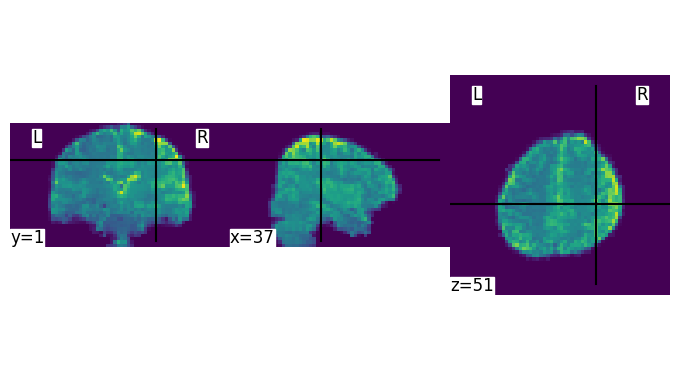

In [20]:
sub_idx = 20
session_idx = 1

# one fMRI example
example_func_brain = f'natview/data/sub-{sub_idx:02d}/ses-{session_idx:02d}/func/sub-{sub_idx:02d}_ses-01_task-monkey1_run-01_bold/func_minimal/example_func_brain.nii.gz'
plotting.plot_img(example_func_brain)

# Full fMRI trial
func_mc = f'natview/data/sub-{sub_idx:02d}/ses-{session_idx:02d}/func/sub-{sub_idx:02d}_ses-{session_idx:02d}_task-monkey1_run-01_bold/func_minimal/func_mc.nii.gz'
nii_img = nib.load(func_mc)

# Get the data as a numpy array
data = nii_img.get_fdata()
data.shape

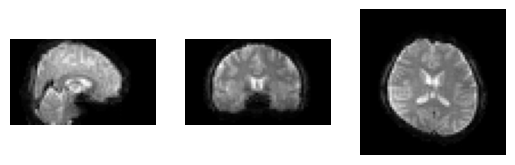

In [21]:
t = 10
slice_0 = data[data.shape[0] // 2, :, :, t]
slice_1 = data[:, data.shape[1] // 2, :, t]
slice_2 = data[:, :, data.shape[2] // 2, t]

show_slices([slice_0, slice_1, slice_2])

In [22]:
print(np.max(data), np.min(data))

2893.18310546875 -0.015011072158813477


## Filtered data

(61, 73, 61, 145)


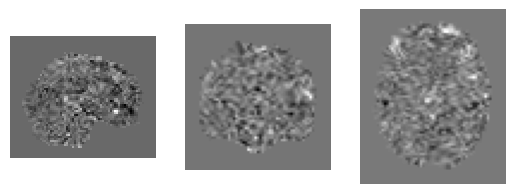

1552.726318359375 -1259.8145751953125


In [5]:
sub_idx = 1
session_idx = 1

data_path = f'natview/data/sub-{sub_idx:02d}/ses-{session_idx:02d}/func/sub-{sub_idx:02d}_ses-{session_idx:02d}_task-monkey1_run-01_bold/func_preproc/func_pp_filter_gsr_sm0.mni152.3mm.nii.gz'
nii_img = nib.load(data_path)

# Get the data as a numpy array
data = nii_img.get_fdata()
print(data.shape)

t = 100
slice_0 = data[data.shape[0] // 2, :, :, t]
slice_1 = data[:, data.shape[1] // 2, :, t]
slice_2 = data[:, :, data.shape[2] // 2, t]

show_slices([slice_0, slice_1, slice_2])

print(np.max(data), np.min(data))

In [25]:
# Background zero
data[0,0,0,0]

np.float64(0.0)

## ROI and Masks

(64, 64, 38)


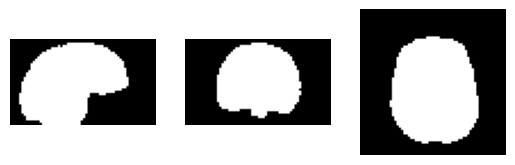

In [26]:
sub_idx = 5
session_idx = 1

mask_path = f'natview/data/sub-{sub_idx:02d}/ses-{session_idx:02d}/func/sub-{sub_idx:02d}_ses-{session_idx:02d}_task-monkey1_run-01_bold/func_seg/global_mask.nii.gz'
nii_mask = nib.load(mask_path)
mask = nii_mask.get_fdata()
print(mask.shape)
slice_0 = mask[mask.shape[0] // 2, :, :]
slice_1 = mask[:, mask.shape[1] // 2, :]
slice_2 = mask[:, :, mask.shape[2] // 2]

show_slices([slice_0, slice_1, slice_2])

(64, 64, 38)


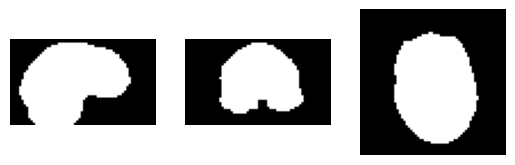

In [27]:
sub_idx = 22
session_idx = 1

mask_path = f'natview/data/sub-{sub_idx:02d}/ses-{session_idx:02d}/func/sub-{sub_idx:02d}_ses-{session_idx:02d}_task-monkey1_run-01_bold/func_reg/func_pp_mask.nii.gz'
nii_mask = nib.load(mask_path)
mask = nii_mask.get_fdata()
print(mask.shape)
slice_0 = mask[mask.shape[0] // 2, :, :]
slice_1 = mask[:, mask.shape[1] // 2, :]
slice_2 = mask[:, :, mask.shape[2] // 2]

show_slices([slice_0, slice_1, slice_2])

# Print fMRI Shapes

In [11]:
# sub_idx = 1
# session_idx = 1

# for sub_idx in range(1, 23):

#     data_path = f'natview/data/sub-{sub_idx:02d}/ses-{session_idx:02d}/func/sub-{sub_idx:02d}_ses-{session_idx:02d}_task-monkey1_run-01_bold/func_preproc/func_pp_filter_sm0.mni152.3mm.nii.gz'
#     nii_img = nib.load(data_path)
#     data = nii_img.get_fdata()
#     print(data.shape)

# Getting Brain Masks

In [41]:
sub_idx = 1
session_idx = 1

# data_path = f'natview/data/sub-{sub_idx:02d}/ses-{session_idx:02d}/func/sub-{sub_idx:02d}_ses-{session_idx:02d}_task-monkey1_run-01_bold/func_preproc/func_pp_filter_gsr_sm0.mni152.3mm.nii.gz'
data_path = f'natview/data/sub-{sub_idx:02d}/ses-{session_idx:02d}/func/sub-{sub_idx:02d}_ses-{session_idx:02d}_task-dme_run-01_bold/func_preproc/func_pp_filter_gsr_sm0.mni152.3mm.nii.gz'
nii_img = nib.load(data_path)

# Get the data as a numpy array
data = torch.tensor(nii_img.get_fdata())

In [42]:
# !python -m pip install -U scikit-image

In [43]:
mask = get_thresholded_change_mask(data)

In [134]:
torch.sum(mask)

tensor(78289)

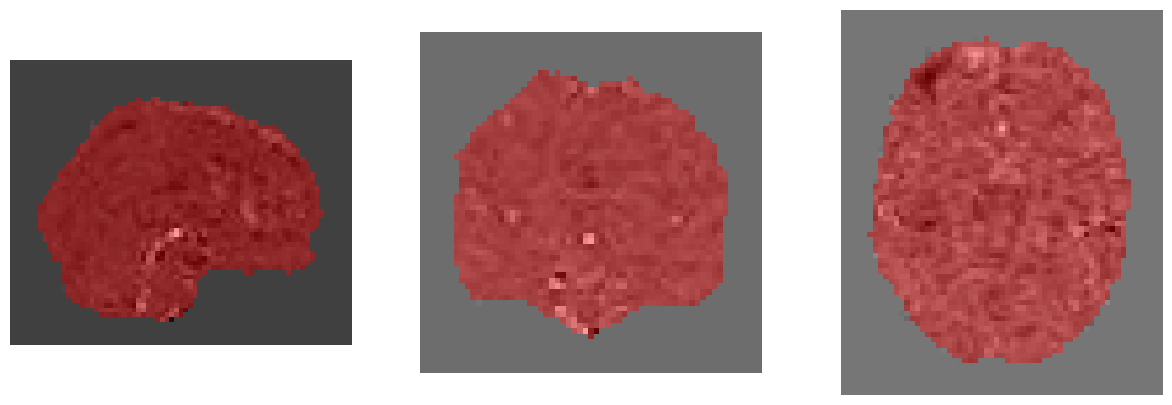

In [129]:
show_slices_with_mask(data[:,:,:,0], mask)

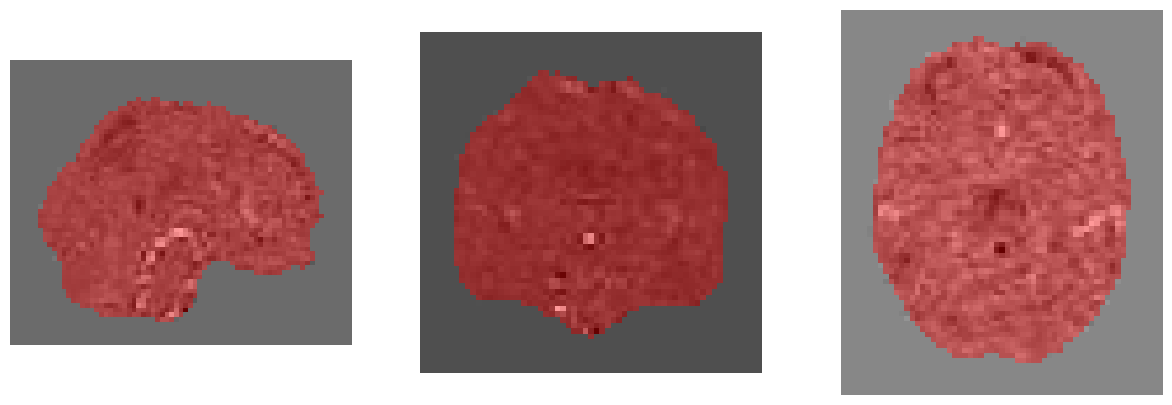

In [124]:
show_slices_with_mask(data[:,:,:,0], mask)

# Getting masks for all subs

In [15]:
json_file_path = "/home/jovyan/shares/SR004.nfs2/nkiselev/visual_stimuli_reconstruction/CreationOfIntelligentSystems_Simultaneous_fMRI-EEG/code/data/sub2fmripaths.json"

with open(json_file_path, 'r') as json_file:
    sub_num2paths = json.load(json_file)

In [24]:
sub_num2masks = {}
for sub, paths in tqdm(sub_num2paths.items()):
    sub_num2masks[sub] = torch.stack([get_thresholded_change_mask(torch.tensor(nib.load(path).get_fdata())) for path in paths])

100%|██████████| 22/22 [10:16<00:00, 28.02s/it]


In [48]:
combined_mask = np.zeros((61, 73, 61))  # Initialize with zeros
# Combine the masks using element-wise logical OR
masks = sub_num2masks["sub-01"].numpy()
for mask in masks:
    combined_mask = np.logical_or(combined_mask, mask)

In [49]:
combined_mask.sum()

np.int64(81391)

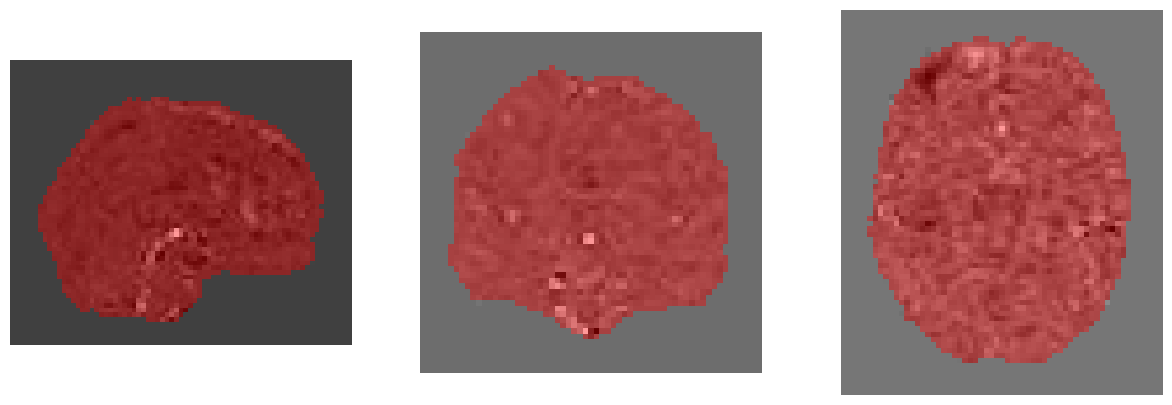

In [45]:
show_slices_with_mask(data[:,:,:,0], torch.tensor(combined_mask))

In [51]:
fmri_tensor = data[:,:,:,0].unsqueeze(0)

In [ ]:
def apply_mask_and_flatten(fmri_batch, mask):
    """
    Applies a mask to a batch of FMRI tensors and returns a batch of vectors.

    :param fmri_batch: Tensor of shape (batch_size, depth, height, width)
    :param mask: Tensor of shape (depth, height, width) with values 0 and 1
    :return: Tensor of shape (batch_size, num_masked_voxels)
    """
    # Apply the mask to each element in the batch
    masked_batch = fmri_batch * mask.unsqueeze(0)  # Expand the mask to the batch size
    # Flatten the tensor and keep only the active voxels
    flattened_batch = masked_batch.reshape(fmri_batch.size(0), -1)  # Reshape to (batch_size, depth * height * width)
    # Keep only the active voxels
    active_voxels = flattened_batch[:, mask.view(-1) == 1]

    return active_voxels

In [58]:
vec = apply_mask_and_flatten(fmri_tensor, torch.tensor(combined_mask))

In [59]:
vec.shape

torch.Size([1, 81391])

# EEG

In [12]:
sub_idx = 1
session_idx = 1

path = f'natview/data/sub-{sub_idx:02d}/ses-{session_idx:02d}/eeg/sub-{sub_idx:02d}_ses-{session_idx:02d}_task-dme_run-01_eeg.set'

raw_data = read_raw_eeglab(path)
data = np.array(raw_data.get_data())
data.shape

/tmp/ipykernel_1591383/833325554.py:6: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw_data = read_raw_eeglab(path)
/tmp/ipykernel_1591383/833325554.py:6: RuntimeWarning: Limited 3 annotation(s) that were expanding outside the data range.
  raw_data = read_raw_eeglab(path)
/tmp/ipykernel_1591383/833325554.py:6: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = read_raw_eeglab(path)


(60, 146875)

In [13]:
raw_data

<RawEEGLAB | sub-01_ses-01_task-dme_run-01_eeg.set, 60 x 146875 (587.5 s), ~67.3 MB, data loaded>

<Axes: >

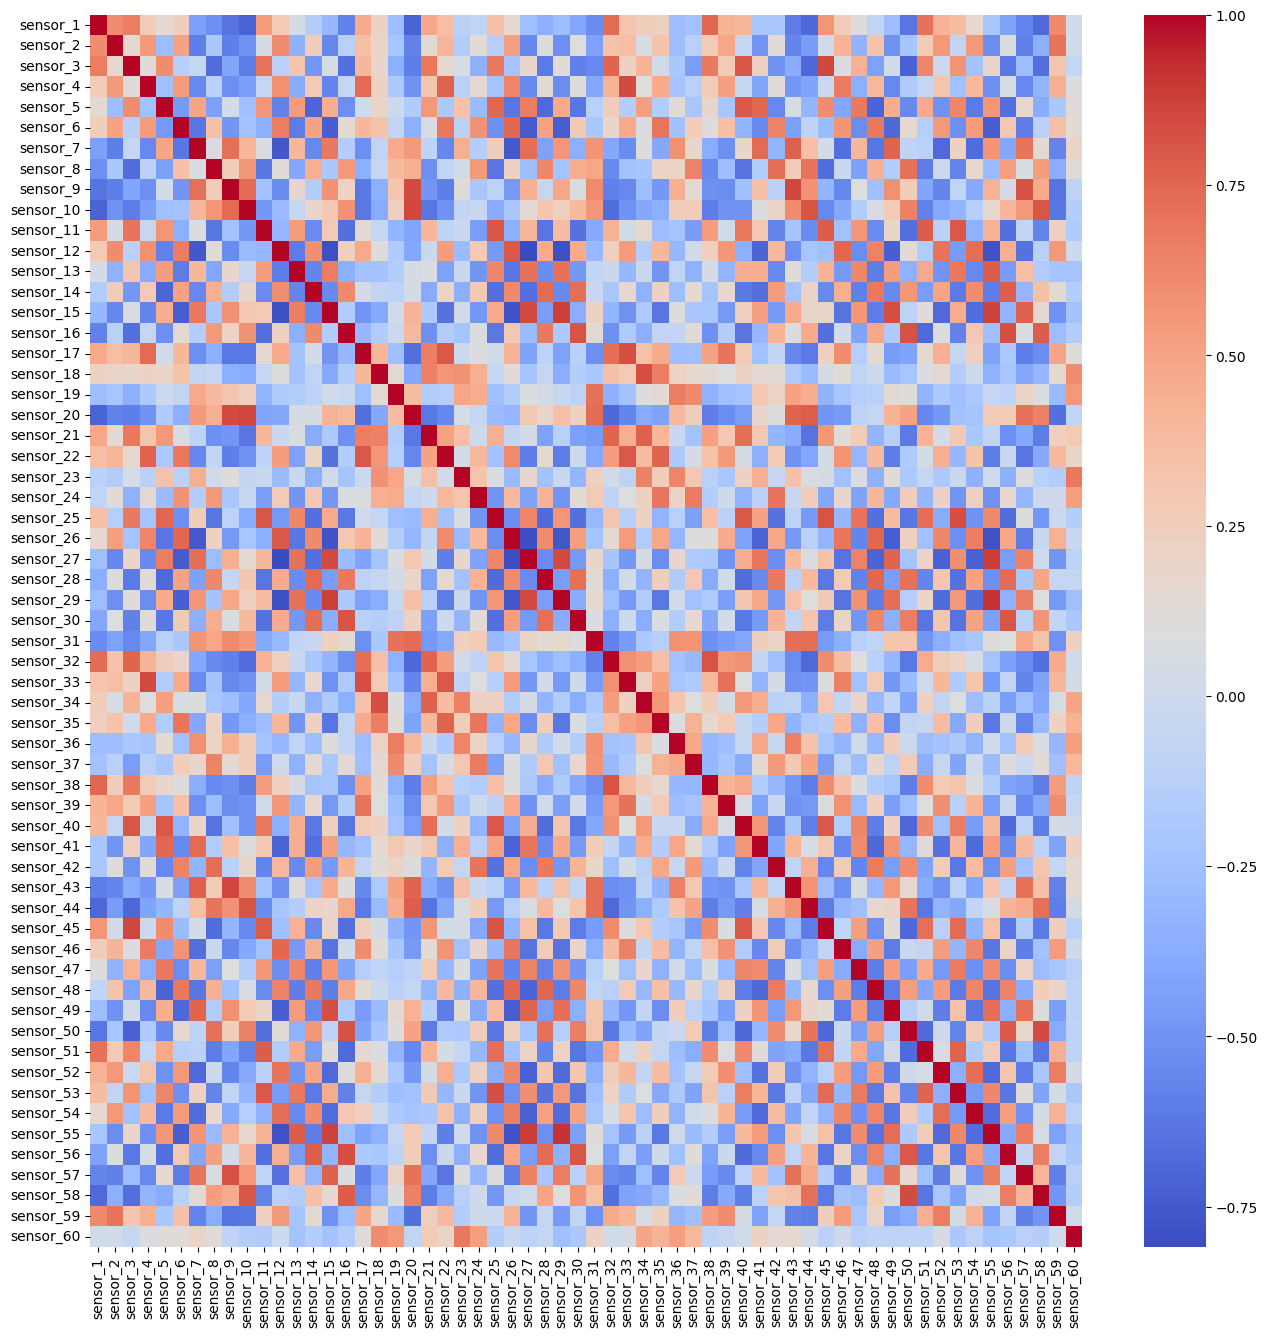

In [14]:
df = pd.DataFrame(data.T, columns=[f'sensor_{i+1}' for i in range(data.T.shape[1])])
plt.figure(figsize=(16, 16))
sns.heatmap(df.corr(method='pearson'), cmap='coolwarm')

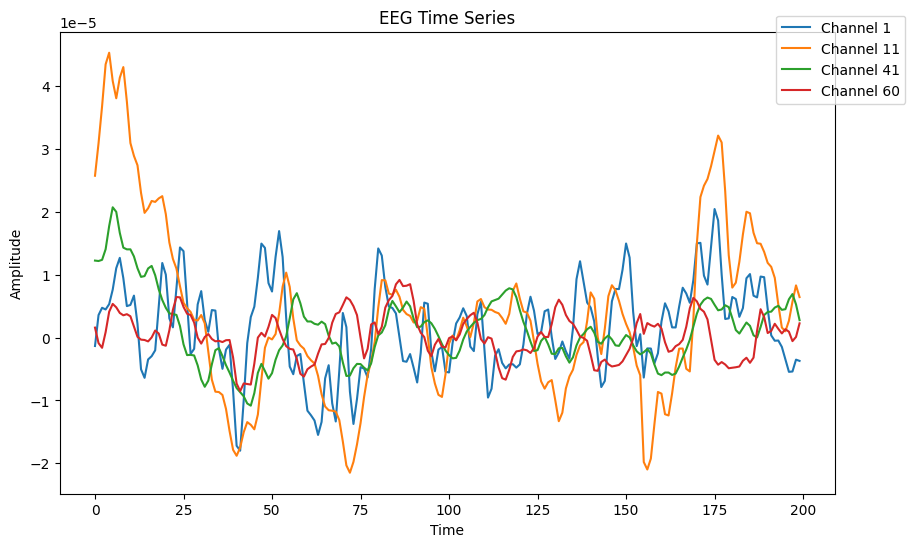

In [15]:
fig, ax = plt.subplots(figsize=(10, 6))
# for i in range(data.shape[0]//15):
for i in [0, 10, 40, 59]:
    ax.plot(data[i, :200], label=f'Channel {i+1}')

ax.set_title('EEG Time Series')
ax.set_xlabel('Time')
ax.set_ylabel('Amplitude')

ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.05))
plt.show()